**Covid19 Trend Analysis for Recovery Phase Prediction**

Source Datasets:

1. Our World in Data COVID-19 Testing dataset https://ourworldindata.org/coronavirus-testing
1. Google Covid19 Community Mobility Reports https://www.google.com/covid19/mobility/

Methdology:

1. Calculate Start of Impact of Covid in a country with 1 case per 1000 population
1. Plot the line chart (new cases per 1000 population rolling average 7 days) for: 
  *   Most Affected Countries excluding USA,
  *   Least Affected Countries
  *   USA+some other more affected countries not following overall trend.
1. Observe that in most countries Covid is getting to manageable levels in 90-100 days from impact date. Some countries are different like USA, India, Iran but overall they should follow the same pattern only taking a bit longer than other countries.

Note: #rolling average of new cases smoothens the graphs presented.

In [0]:
#load coviddata dataset
import pandas as pd
url="https://covid.ourworldindata.org/data/owid-covid-data.csv"
coviddata=pd.read_csv(url)
#coviddata = coviddata[coviddata['date']>='2020-03-01']

#change data types and column names
coviddata['date'] = pd.to_datetime(coviddata['date'])
coviddata['total_cases_per_million'] = pd.to_numeric(coviddata['total_cases_per_million'])
coviddata['total_cases_per_thousand'] = pd.to_numeric(coviddata['total_cases_per_million']*1000)
coviddata.rename(columns={'iso_code':'iso3_code'}, inplace=True)

#filter out negative values
coviddata = coviddata[coviddata.new_cases >= 0]
coviddata = coviddata[coviddata.new_deaths >= 0]

#filter out 'world' and 'international' data
coviddata = coviddata[coviddata.location != 'World']
coviddata = coviddata[coviddata.location != 'International']

#display(coviddata)

In [0]:
# Assumption Covid started impacting the country when total_cases_per_thousand population > 1
# Similar assumption can be made it ended when there were less than x amount of new cases per 1000 of population.
Covid_Impact_Date = coviddata

Covid_Impact_Date = Covid_Impact_Date[Covid_Impact_Date.total_cases_per_thousand >= 1]

Covid_Impact_Date_Agg = Covid_Impact_Date.groupby([Covid_Impact_Date.iso3_code]).agg({'date':'min'}).reset_index()

Covid_Impact_Date_Agg = Covid_Impact_Date_Agg.rename(columns={"date": "impact_date"}, errors="raise")

#display(Covid_Impact_Date_Agg)


In [0]:
#join datasets for covid_impact_date

master = pd.merge(coviddata, Covid_Impact_Date_Agg, on="iso3_code")

master['covid_day'] = (master['date'] - master['impact_date']).dt.days
master['new_cases_per_thousand'] = (master['new_cases_per_million'] * 100)

# filter out dates  before covid impact (negative covid_day values)
master = master[master.covid_day >= 0]

#master

In [0]:
# attempting to get rolling average of new_cases
# window 
# check result, source should be in the correct order to do so.

#subset
my_subset = master[['iso3_code','location','date','covid_day','new_cases','new_cases_per_thousand']] #.reset_index()
#display(my_subset)

# compute values for columns new_cases, new_cases_per_thousand
df_ = my_subset.loc[:, ['new_cases', 'new_cases_per_thousand']]
numerator = df_.fillna(0).rolling(window=7, min_periods=7).sum()
denominator = df_.notnull().astype(int).rolling(window=7).sum()

# New DataFrame containing results for columns new_cases, new_cases_per_thousand
new_df = numerator / denominator

#display(new_df)



In [0]:
# final DataFrame
final_df = my_subset[['iso3_code','location','date','covid_day']].join(new_df)

#display(final_df)

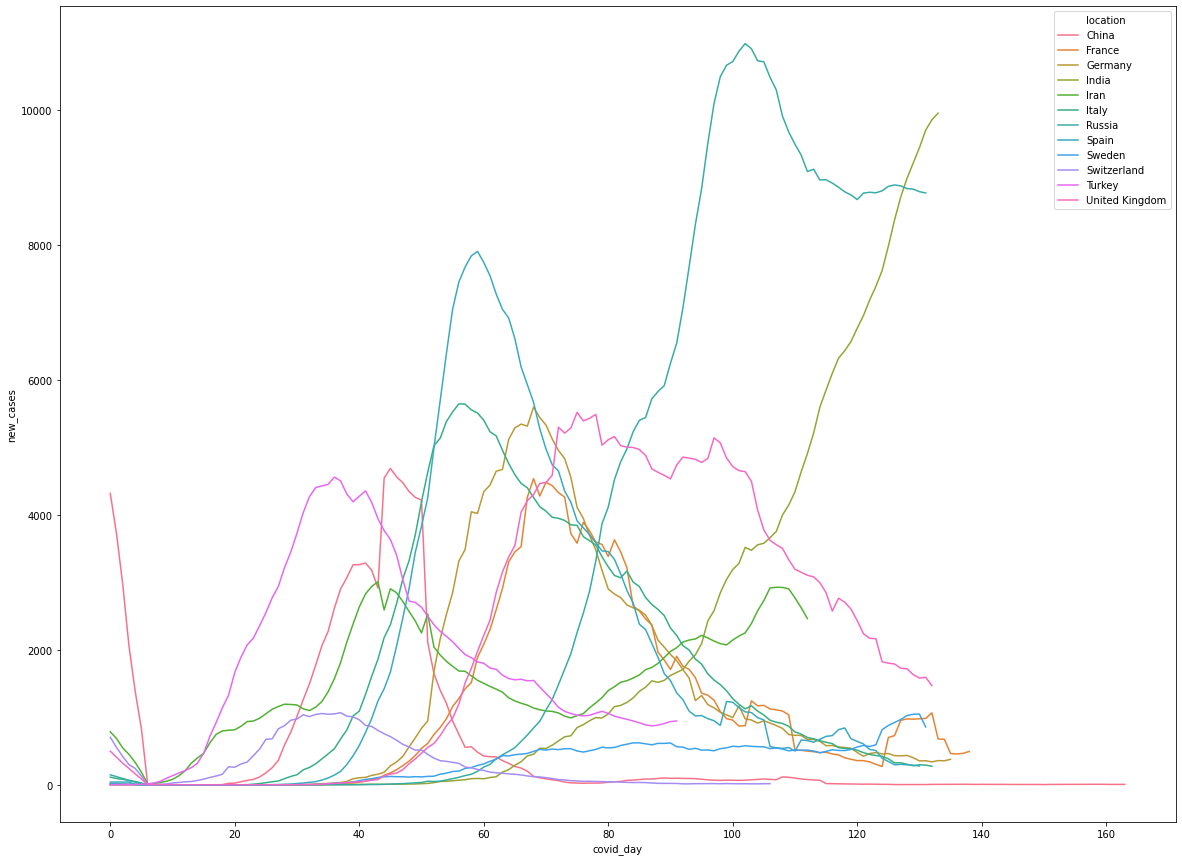

None

In [16]:
#plot new cases by covid_day - most affected countries except USA
#rolling average of new cases smoothens the graphs presented.
#just using new_cases without relating it to population shows us a different picture compared to when we use affected new cases per 1000 population.

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['CHN', 'FRA', 'IND', 'ITA', 'IRN', 'ESP', 'CHE', 'TUR', 'GBR','RUS','DEU','SWE']
#master_selection=master[(master['iso3_code'].isin(countrys))]
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]

ax = sns.lineplot(x="covid_day", y="new_cases", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())

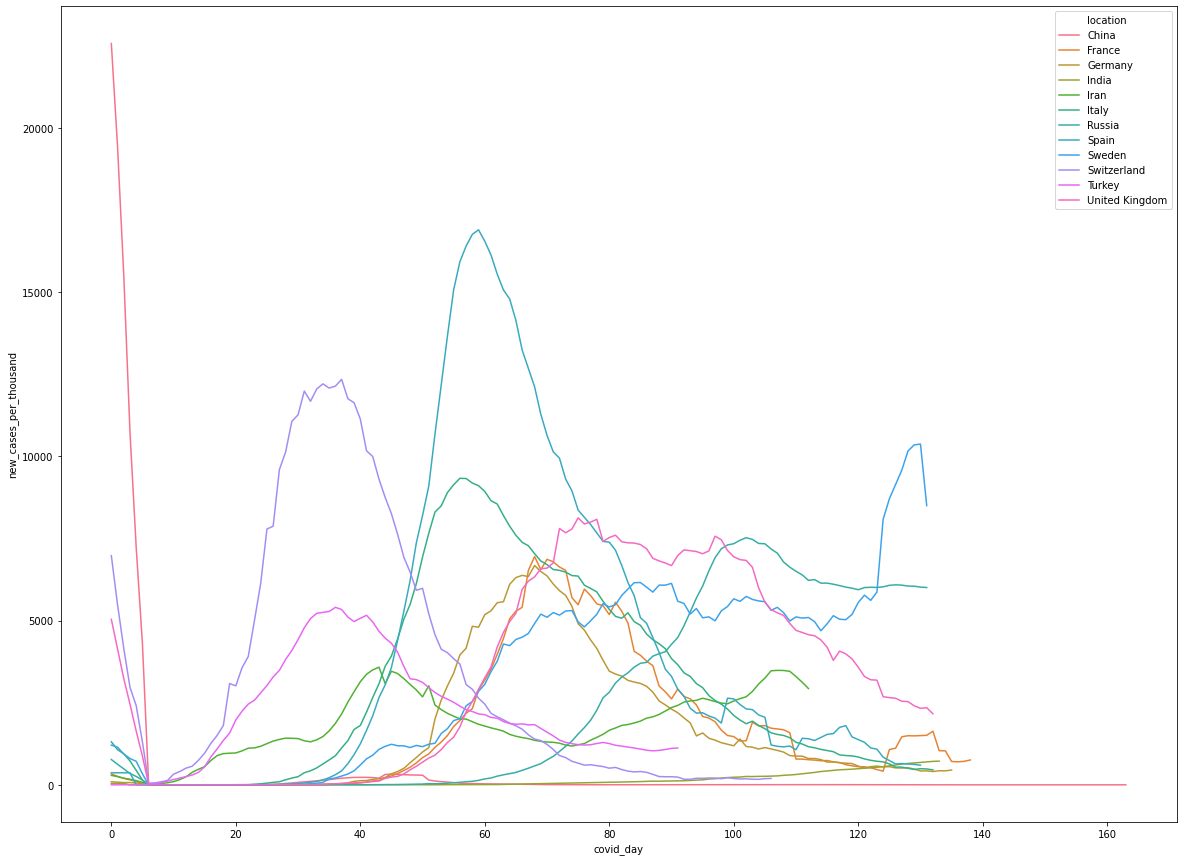

None

In [17]:
#plot new cases by covid_day - most affected countries except USA
#rolling average of new cases per thousand smoothens the graphs presented.
#although countries like India, China have huge numbers of cases, it is relativity lower per 1000 of population of other countries.

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['CHN', 'FRA', 'IND', 'ITA', 'IRN', 'ESP', 'CHE', 'TUR', 'GBR','RUS','DEU','SWE']
#master_selection=master[(master['iso3_code'].isin(countrys))]
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]

ax = sns.lineplot(x="covid_day", y="new_cases_per_thousand", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())

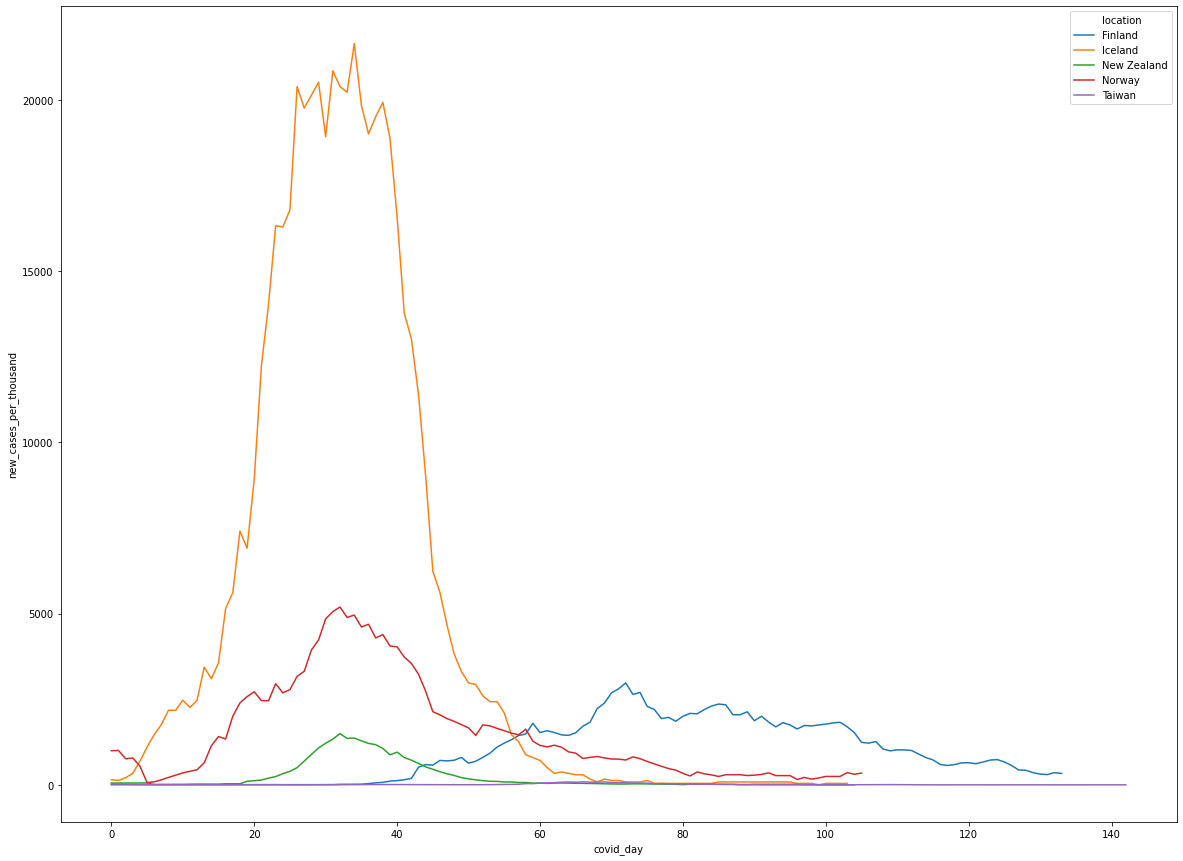

None

In [18]:
#plot new cases by covid_day - least affected countries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['ISL', 'FIN', 'NOR', 'NZL', 'TWN']
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]
#master_selection=master[(master['iso3_code'].isin(countrys))]
ax = sns.lineplot(x="covid_day", y="new_cases_per_thousand", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())

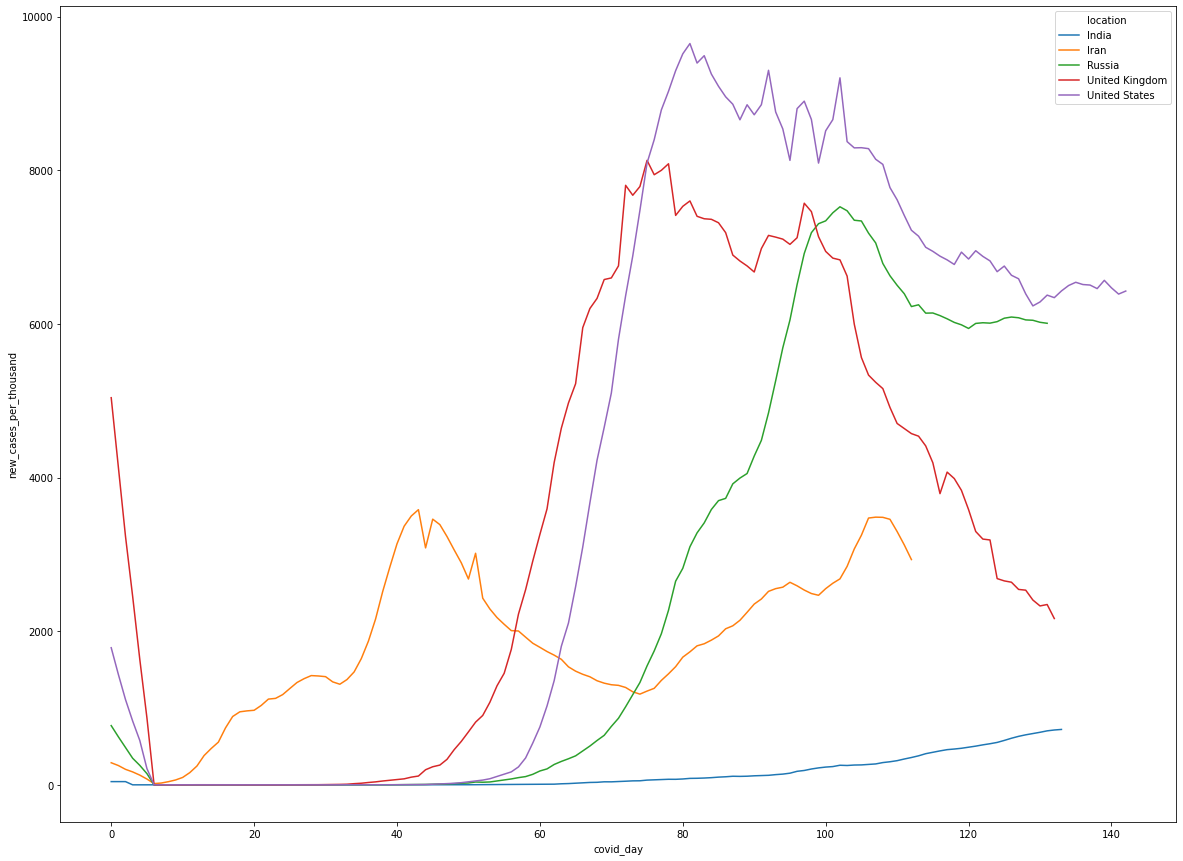

None

In [19]:
#plot new cases by covid_day - USA and Russia
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['USA','RUS','IND', 'IRN','GBR']
#master_selection=master[(master['iso3_code'].isin(countrys))]
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]
ax = sns.lineplot(x="covid_day", y="new_cases_per_thousand", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())